## Regression with a Crab Age Dataset
## Junfei Ma | Crystal Cui | Shuangqing Li | Chengcheng Le

### https://www.kaggle.com/competitions/playground-series-s3e16


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import time
import warnings
warnings.filterwarnings("ignore")

In [48]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
train

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...,...
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


In [4]:
test

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066
...,...,...,...,...,...,...,...,...,...
49363,123414,F,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309
49364,123415,I,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687
49365,123416,F,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345
49366,123417,F,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163


## Data Exploration

In [5]:
train.nunique()

id                74051
Sex                   3
Length              144
Diameter            122
Height               65
Weight             3096
Shucked Weight     1766
Viscera Weight      967
Shell Weight       1048
Age                  28
dtype: int64

In [6]:
train.isnull().sum(), test.isnull().sum()

(id                0
 Sex               0
 Length            0
 Diameter          0
 Height            0
 Weight            0
 Shucked Weight    0
 Viscera Weight    0
 Shell Weight      0
 Age               0
 dtype: int64,
 id                0
 Sex               0
 Length            0
 Diameter          0
 Height            0
 Weight            0
 Shucked Weight    0
 Viscera Weight    0
 Shell Weight      0
 dtype: int64)

In [7]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [8]:
test.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


## Data cleaning&Processing

#### 1. Outliers (Ex: Height : Min value is 0)

In [9]:
train.sort_values(by = ['Length'])

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
1996,1996,I,0.187500,0.1375,0.0625,0.056699,0.028349,0.075049,0.042524,4
31683,31683,I,0.187500,0.1375,0.0250,0.056699,0.028349,0.042524,0.042524,4
15366,15366,I,0.275000,0.2250,0.0750,0.226796,0.070874,0.056699,0.056699,3
3484,3484,I,0.275000,0.2375,0.0375,0.354369,0.141747,0.085048,0.141747,4
25973,25973,I,0.287500,0.2625,0.0875,0.297670,0.184272,0.099223,0.141747,4
...,...,...,...,...,...,...,...,...,...,...
54816,54816,M,1.950000,1.3750,0.4875,49.342305,23.572609,12.076887,12.190285,12
60098,60098,F,1.950000,1.4375,0.4750,60.242688,29.895908,10.574364,15.733973,12
11208,11208,F,1.950000,1.5750,0.5375,75.324622,42.184056,14.132226,16.612807,29
3937,3937,F,1.950000,1.4125,0.5375,72.234526,33.863478,14.840963,17.038049,10


In [10]:
train.loc[(train['Height'] == 0)].sort_values(by = ['Weight'])

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
28362,28362,I,0.387500,0.2625,0.0,0.496116,0.141747,0.099223,0.141747,3
51660,51660,I,0.400000,0.3000,0.0,0.510291,0.255146,0.226796,0.141747,4
63685,63685,I,0.400000,0.3125,0.0,0.595340,0.212621,0.127573,0.141747,4
56641,56641,I,0.475000,0.3250,0.0,0.765436,0.354369,0.141747,0.255146,4
9320,9320,I,0.462500,0.3250,0.0,0.893009,0.354369,0.141747,0.269320,7
51907,51907,I,0.537500,0.4125,0.0,1.063106,0.510291,0.340194,0.425243,4
16301,16301,I,0.437500,0.3625,0.0,1.077281,0.467767,0.184272,0.255146,4
13456,13456,I,0.575000,0.4000,0.0,1.304077,0.467767,0.340194,0.382718,3
15463,15463,I,0.500000,0.4000,0.0,1.318252,0.411068,0.226796,0.283495,4
63366,63366,I,0.625000,0.4375,0.0,1.743494,0.581165,0.269320,0.566990,4


根据age分组然后用ml的package自动填充Height = 0的值
或者直接删除

#### Shucked Weight + Viscera Weight + Shell Weight >= Weight

In [11]:
train['Weight_sum']= train['Shucked Weight']+ train['Viscera Weight']+ train['Shell Weight']
train['Weight_diff'] = train['Weight_sum'] - train['Weight']

In [12]:
train.loc[(train['Weight']<train['Weight_sum'])].sort_values(by = ['Weight_diff'])

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Weight_sum,Weight_diff
1462,1462,I,0.4125,0.2750,0.0875,0.411068,0.184272,0.085048,0.141747,4,0.411068,5.551115e-17
67832,67832,I,0.3500,0.2625,0.0625,0.411068,0.155922,0.113398,0.141747,4,0.411068,5.551115e-17
44474,44474,I,0.3375,0.2625,0.1375,0.382718,0.141747,0.099223,0.141747,4,0.382718,5.551115e-17
43496,43496,I,0.4500,0.3250,0.1125,0.751262,0.269320,0.226796,0.255146,4,0.751262,1.110223e-16
49599,49599,I,0.4375,0.3250,0.1125,0.893009,0.354369,0.184272,0.354369,5,0.893009,1.110223e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
32945,32945,I,0.6875,0.5000,0.1750,2.990872,14.033003,0.538640,0.893009,5,15.464652,1.247378e+01
50101,50101,I,0.6875,0.5000,0.1750,2.990872,14.132226,0.524466,0.878834,5,15.535526,1.254465e+01
2296,2296,I,0.6875,0.5125,0.1750,2.990872,14.033003,0.538640,0.992232,5,15.563875,1.257300e+01
37581,37581,F,0.6625,0.5000,0.1750,2.990872,14.033003,0.538640,0.992232,7,15.563875,1.257300e+01


Weight相差不大的可以不管，相差大的讨论一下如何解决

## Modeling

In [13]:
X = train.drop(columns=['id','Age'])
y = train['Age']

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Weight_sum,Weight_diff
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,27.725811,-1.247378
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,10.248344,-0.170097
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,23.558434,-1.219029
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,46.343665,-4.316891
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,22.438629,-0.850485
...,...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,43.374735,-7.285821
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,10.163296,-0.283495
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,27.924258,-1.559222
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,16.173390,-0.595340


In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']),
    ('cat', OneHotEncoder(), ['Sex'])])

In [17]:
rf = RandomForestRegressor(random_state=42)
xgb = xgb.XGBRegressor(random_state=42)
lgbm = lgb.LGBMRegressor(random_state=42)
cat = CatBoostRegressor(random_state=42)

In [18]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', rf)])

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb)])

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm)])

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat)])

In [19]:
rf_params = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [10, 20, 30, 40, 50, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

In [20]:
xgb_params = {
    'regressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'regressor__max_depth': [2, 3, 5, 7, 9, 11],
    'regressor__subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__min_child_weight': [1, 3, 5, 7, 10],
    'regressor__gamma': [0, 0.5, 1, 1.5, 2, 2.5, 3],
    'regressor__scale_pos_weight': [1, 10, 25, 50, 75, 100],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],
    'regressor__reg_lambda': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
}

In [21]:
lgbm_params = {
    'regressor__num_leaves': [7, 14, 31, 62],
    'regressor__max_depth': [3, 4, 5, 6, -1],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [200, 400, 600, 800],
    'regressor__subsample_for_bin': [20000, 50000, 100000, 200000],
    'regressor__min_split_gain': [0, 0.001, 0.01],
    'regressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'regressor__subsample': [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [22]:
cat_params = {
    'regressor__iterations': [100, 200, 300, 500],
    'regressor__depth': [4, 5, 6, 7, 8, 9, 10],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'regressor__l2_leaf_reg': [1, 3, 5, 7, 9],
    'regressor__border_count': [32, 5, 10, 20, 50, 100, 200],
    'regressor__loss_function': ['RMSE', 'MAE', 'Quantile']
}

In [23]:
#Comment out for performing a gird search
"""
# Start the timer
start_time = time.time()

rf_random_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for RandomForest: {rf_random_search.best_params_}")
"""

'\n# Start the timer\nstart_time = time.time()\n\nrf_random_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)\nrf_random_search.fit(X_train, y_train)\n\n# End the timer and print the elapsed time\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nminutes, seconds = divmod(elapsed_time, 60)\nprint("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))\nprint(" ")\nprint(f"Best parameters for RandomForest: {rf_random_search.best_params_}")\n'

Time taken for Randomized Search: 51 minutes 53 seconds

In [36]:
rf = RandomForestRegressor(n_estimators=400,
                           min_samples_split=10,
                           min_samples_leaf=4,
                           max_features='sqrt',
                           max_depth=20,
                           bootstrap=True,
                           random_state=42)

In [25]:
#Comment out for performing a gird search
"""
# Start the timer
start_time = time.time()

xgb_random_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
xgb_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")
"""

'\n# Start the timer\nstart_time = time.time()\n\nxgb_random_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)\nxgb_random_search.fit(X_train, y_train)\n\n# End the timer and print the elapsed time\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nminutes, seconds = divmod(elapsed_time, 60)\nprint("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))\nprint(" ")\nprint(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")\n'

Time taken for Randomized Search: 10 minutes 0 seconds

In [28]:
import xgboost as xgb
xgb = xgb.XGBRegressor(subsample=0.8,
                       scale_pos_weight=50,
                       reg_lambda=4,
                       reg_alpha=0,
                       n_estimators=400,
                       min_child_weight=7,
                       max_depth=5,
                       learning_rate=0.05,
                       gamma=1,
                       colsample_bytree=0.8)

In [29]:
#Comment out for performing a gird search
"""
# Start the timer
start_time = time.time()

lgbm_random_search = RandomizedSearchCV(lgbm_pipeline, lgbm_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
lgbm_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time


minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for LGMB: {lgbm_random_search.best_params_}")
"""

'\n# Start the timer\nstart_time = time.time()\n\nlgbm_random_search = RandomizedSearchCV(lgbm_pipeline, lgbm_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)\nlgbm_random_search.fit(X_train, y_train)\n\n# End the timer and print the elapsed time\nend_time = time.time()\nelapsed_time = end_time - start_time\n\n\nminutes, seconds = divmod(elapsed_time, 60)\nprint("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))\nprint(" ")\nprint(f"Best parameters for LGMB: {lgbm_random_search.best_params_}")\n'

Time taken for Randomized Search: 1 minutes 23 seconds

In [30]:
lgbm = lgb.LGBMRegressor(subsample_for_bin=200000,
                               subsample=0.7,
                               num_leaves=7,
                               n_estimators=800,
                               min_split_gain=0,
                               min_child_weight=100.0,
                               max_depth=4,
                               learning_rate=0.1,
                               colsample_bytree=0.9)

In [31]:
#Comment out for performing a gird search
"""
# Start the timer
start_time = time.time()

cat_random_search = RandomizedSearchCV(cat_pipeline, cat_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
cat_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for CatBoost: {cat_random_search.best_params_}")
"""

'\n# Start the timer\nstart_time = time.time()\n\ncat_random_search = RandomizedSearchCV(cat_pipeline, cat_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)\ncat_random_search.fit(X_train, y_train)\n\n# End the timer and print the elapsed time\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nminutes, seconds = divmod(elapsed_time, 60)\nprint("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))\nprint(" ")\nprint(f"Best parameters for CatBoost: {cat_random_search.best_params_}")\n'

Time taken for Randomized Search: 4 minutes 57 seconds

In [32]:
cat = CatBoostRegressor(loss_function='RMSE',
                                   learning_rate=0.1,
                                   l2_leaf_reg=5,
                                   iterations=500,
                                   depth=5,
                                   border_count=200)

In [38]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', rf)])

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb)])

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm)])

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat)])

In [44]:
"""
pipelines = [rf_pipeline, xgb_pipeline, lgbm_pipeline, cat_pipeline]


num_folds = 10  # Number of cross-validation folds

# Perform cross-validation and store R-squared scores
scores = []
for pipeline, model_name in zip(pipelines):
    model_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring='r2')
    scores.append(model_scores)

scores
"""

"\npipelines = [rf_pipeline, xgb_pipeline, lgbm_pipeline, cat_pipeline]\nmodels = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']\n\nnum_folds = 10  # Number of cross-validation folds\n\n# Perform cross-validation and store R-squared scores\nscores = []\nfor pipeline, model_name in zip(pipelines, models):\n    model_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring='r2')\n    scores.append(model_scores)\n\nscores\n"

In [45]:
scores = [
    [0.5810072, 0.58763956, 0.58822255, 0.58621534, 0.58275919,
     0.59589913, 0.58201326, 0.5719473, 0.59583001, 0.55914274],
    [0.58282471, 0.59189613, 0.59528336, 0.59018996, 0.58866753,
     0.60233839, 0.58684222, 0.57512217, 0.59782599, 0.5651888],
    [0.58490538, 0.59052942, 0.59331061, 0.59215291, 0.58832854,
     0.60576346, 0.58838484, 0.5775467, 0.59902527, 0.56518318],
    [0.58437871, 0.5917907, 0.59527333, 0.59100577, 0.58796248,
     0.60251697, 0.58703767, 0.57491664, 0.59713046, 0.56378949]
]

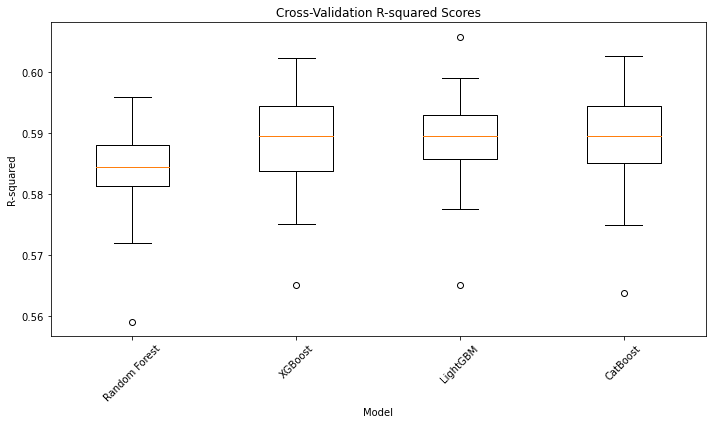

In [50]:
# Plotting the results
models = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(scores, labels=models)
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
ax.set_title('Cross-Validation R-squared Scores')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
test_ids = test['id']
X_test = test.drop(columns=['id'])

In [52]:
xgb_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Weight',
                                                   'Shucked Weight',
                                                   'Viscera Weight',
                                                   'Shell Weight']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex'])])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8, early_s...
                              feature_types=None, gamma=1, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=7,
                              missing=nan, monotone_constraints='()',
                              n_estimators=400, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

In [53]:
y_test_pred = xgb_pipeline.predict(X_test)

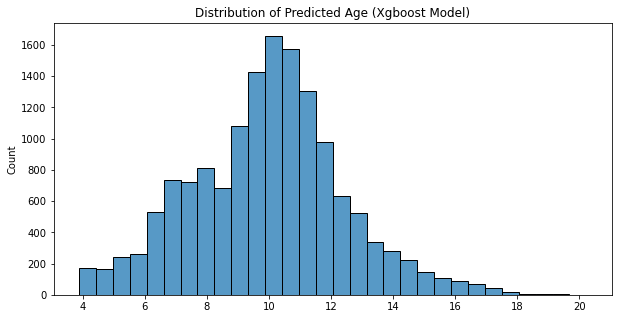

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(y_pred, bins=30)
plt.title('Distribution of Predicted Age (Xgboost Model)')
plt.show()

In [57]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("xgb.csv", index = False)

### Ensemble Model

0:	learn: 3.0347903	total: 3.75ms	remaining: 1.87s
1:	learn: 2.9150041	total: 7.09ms	remaining: 1.76s
2:	learn: 2.8146203	total: 9.98ms	remaining: 1.65s
3:	learn: 2.7278649	total: 13.6ms	remaining: 1.68s
4:	learn: 2.6494150	total: 17.1ms	remaining: 1.69s
5:	learn: 2.5801027	total: 20ms	remaining: 1.65s
6:	learn: 2.5264259	total: 23.3ms	remaining: 1.64s
7:	learn: 2.4788382	total: 26.4ms	remaining: 1.62s
8:	learn: 2.4355004	total: 29.6ms	remaining: 1.62s
9:	learn: 2.3960247	total: 32.7ms	remaining: 1.6s
10:	learn: 2.3638118	total: 35.6ms	remaining: 1.58s
11:	learn: 2.3354230	total: 38.7ms	remaining: 1.57s
12:	learn: 2.3115130	total: 41.9ms	remaining: 1.57s
13:	learn: 2.2906272	total: 44.9ms	remaining: 1.56s
14:	learn: 2.2730808	total: 48.7ms	remaining: 1.57s
15:	learn: 2.2565020	total: 52.4ms	remaining: 1.58s
16:	learn: 2.2417390	total: 56.2ms	remaining: 1.6s
17:	learn: 2.2294349	total: 59.9ms	remaining: 1.6s
18:	learn: 2.2182133	total: 63ms	remaining: 1.59s
19:	learn: 2.2090382	total: 6

173:	learn: 2.0314938	total: 525ms	remaining: 984ms
174:	learn: 2.0311559	total: 529ms	remaining: 982ms
175:	learn: 2.0307839	total: 531ms	remaining: 978ms
176:	learn: 2.0304696	total: 535ms	remaining: 976ms
177:	learn: 2.0304431	total: 538ms	remaining: 974ms
178:	learn: 2.0300988	total: 541ms	remaining: 971ms
179:	learn: 2.0300773	total: 545ms	remaining: 969ms
180:	learn: 2.0297092	total: 549ms	remaining: 967ms
181:	learn: 2.0295156	total: 552ms	remaining: 964ms
182:	learn: 2.0294959	total: 555ms	remaining: 961ms
183:	learn: 2.0290910	total: 558ms	remaining: 959ms
184:	learn: 2.0290683	total: 561ms	remaining: 955ms
185:	learn: 2.0289525	total: 564ms	remaining: 952ms
186:	learn: 2.0287147	total: 567ms	remaining: 949ms
187:	learn: 2.0286733	total: 570ms	remaining: 946ms
188:	learn: 2.0284184	total: 573ms	remaining: 943ms
189:	learn: 2.0281190	total: 576ms	remaining: 940ms
190:	learn: 2.0277244	total: 579ms	remaining: 937ms
191:	learn: 2.0274689	total: 582ms	remaining: 934ms
192:	learn: 

345:	learn: 2.0003259	total: 1.06s	remaining: 471ms
346:	learn: 2.0001026	total: 1.06s	remaining: 467ms
347:	learn: 1.9999249	total: 1.06s	remaining: 465ms
348:	learn: 1.9997053	total: 1.07s	remaining: 462ms
349:	learn: 1.9994558	total: 1.07s	remaining: 459ms
350:	learn: 1.9992867	total: 1.07s	remaining: 456ms
351:	learn: 1.9991096	total: 1.08s	remaining: 453ms
352:	learn: 1.9989654	total: 1.08s	remaining: 450ms
353:	learn: 1.9988775	total: 1.08s	remaining: 447ms
354:	learn: 1.9986452	total: 1.09s	remaining: 444ms
355:	learn: 1.9986094	total: 1.09s	remaining: 441ms
356:	learn: 1.9984935	total: 1.09s	remaining: 438ms
357:	learn: 1.9983136	total: 1.1s	remaining: 435ms
358:	learn: 1.9981075	total: 1.1s	remaining: 432ms
359:	learn: 1.9978897	total: 1.1s	remaining: 429ms
360:	learn: 1.9977212	total: 1.11s	remaining: 426ms
361:	learn: 1.9975389	total: 1.11s	remaining: 423ms
362:	learn: 1.9973954	total: 1.11s	remaining: 420ms
363:	learn: 1.9972307	total: 1.12s	remaining: 417ms
364:	learn: 1.9

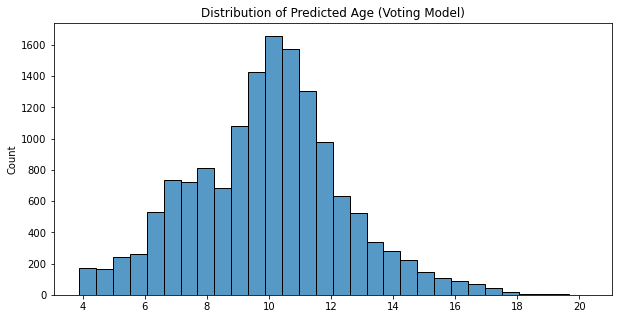

In [58]:
voting_model = VotingRegressor([
    ('xgb', xgb_pipeline),
    ('lgbm', lgbm_pipeline),
    ('cat', cat_pipeline)
])

# Fit the model to the training data
voting_model.fit(X, y)

# Make predictions on the validation data
y_test_pred = voting_model.predict(X_test)

plt.figure(figsize=(10, 5))
sns.histplot(y_pred, bins=30)
plt.title('Distribution of Predicted Age (Voting Model)')
plt.show()

In [59]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("voting_model.csv", index = False)

### next step